### Connecting to the Database

This notebook explores a standard OMOP database, looking at patterns within the person, condition occurrence and visit occurrence tables. It can be used for a basic overview of an OMOP schema and can be edited and tailored to suit the queries you are intrested in exploring further.

In your folder, you will need to save a file called ***database.ini***, which will have the details to allow the notebook to connect to your OMOP database. Below is the template for this file:

[postgresql]  
host=  
database=  
user=  
password=  

In [91]:
#!/usr/bin/python
from configparser import ConfigParser
import psycopg2
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np

def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
    # read connection parameters
        params = config()

    # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
		
    # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')
        
    # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)

	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    return conn


if __name__ == '__main__':
    connect()


Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 11.18, compiled by Visual C++ build 1800, 64-bit',)


##### In line 3 below, you can change the schema name to the name of your OMOP schema for the rest of the notebook to work on your own data. 

In [92]:
conn = connect()
cur = conn.cursor()
schema = "cms_desynpuf_sample_53_large"

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 11.18, compiled by Visual C++ build 1800, 64-bit',)


### A Basic Overview of the data

This section analyses the number of patients, the age and the gender distribution in the database, to get an idea of what the patients "look" like.

##### The number of patients in the database:

In [93]:
cur.execute("SELECT COUNT (*) FROM {}.person".format(schema))
person_count = cur.fetchone()[0]
display(person_count)


1093

##### Gender Analysis

The distibution of Gender in the database:

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/1393689135.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  gender_table = pd.read_sql_query(gender_query, conn)


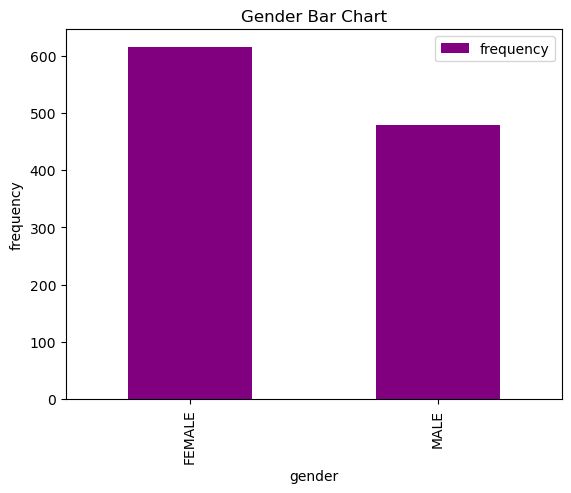

In [94]:
gender_query = \
"""SELECT person.gender_concept_id, concept.concept_name AS Gender,
COUNT(concept.concept_name) AS frequency
FROM {}.person
INNER JOIN {}.concept 
ON person.gender_concept_id = concept.concept_id
GROUP BY concept.concept_name, person.gender_concept_id
""".format(schema, schema)
gender_table = pd.read_sql_query(gender_query, conn)
gender_table.plot.bar(x ='gender', y = 'frequency', color = 'purple', title = 'Gender Bar Chart')
plt.ylabel('frequency')
plt.show()


##### Age Analysis

The boxplots compares the current ages of the patients in the schema, according to their gender. 
- The ages were similar across both genders but females had a slighly larger mean and a greater range. The female patients also had a lot less outliers than the male patients. 

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/1163401001.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  female_age_table = pd.read_sql_query(female_age_query, conn)
/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/1163401001.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  male_age_table = pd.read_sql_query(male_age_query, conn)


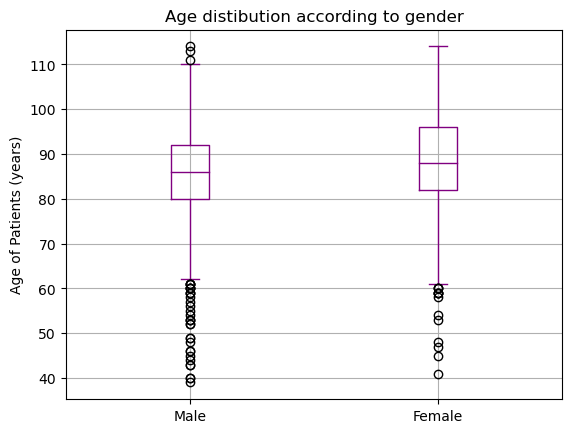

In [95]:
#A definition to calculate the current age of patients
def calculate_age(year_of_birth, month_of_birth, day_of_birth):
    current_date = datetime.now()
    birth_date = datetime(year_of_birth, month_of_birth, day_of_birth)
    age = current_date - birth_date
    years = age.days // 365
    remaining_days = age.days % 365
    remaining_days %= 30
    return f"{years} years"

female_age_query = "SELECT person_id, year_of_birth, month_of_birth, day_of_birth FROM {}.person where person.gender_concept_id = 8532".format(schema)
female_age_table = pd.read_sql_query(female_age_query, conn)
female_age_table['Age'] = female_age_table.apply(lambda row: calculate_age(row['year_of_birth'], row['month_of_birth'], row['day_of_birth']), axis=1).str.replace('years','').astype(float) 
female_age_table.drop(columns=['month_of_birth', 'day_of_birth'], inplace=True) 


male_age_query = "SELECT person_id, year_of_birth, month_of_birth, day_of_birth FROM {}.person where person.gender_concept_id = 8507".format(schema)
male_age_table = pd.read_sql_query(male_age_query, conn)
male_age_table['Age'] = male_age_table.apply(lambda row: calculate_age(row['year_of_birth'], row['month_of_birth'], row['day_of_birth']), axis=1).str.replace('years','').astype(float) 

fig, ax = plt.subplots()
male_age_table.boxplot(column=['Age'], positions = [1], labels=['Male age distribution'], color='purple', )
female_age_table.boxplot(column=['Age'], positions = [2], labels=['Female age distribution'], color='purple' )
ax.set_xticklabels(['Male', 'Female'])
plt.ylabel('Age of Patients (years)')
plt.title('Age distibution according to gender')
plt.show()


##### Length of stay 

Boxplot looking at how long patients stay in hospital each visit.

* split boxplot for race

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/3859265626.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  white_LOS_table = pd.read_sql(white_LOS_query, conn)
/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/3859265626.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  black_LOS_table = pd.read_sql(black_LOS_query, conn)
/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/3859265626.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  other_LOS_table = pd.read_sql(other_

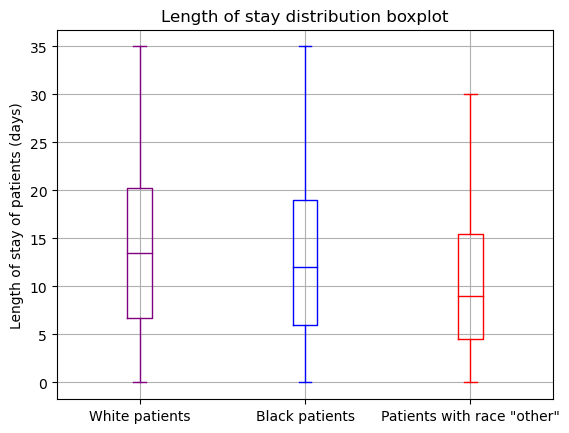

In [96]:
white_LOS_query = \
"""  
SELECT  visit_end_date::DATE - visit_start_date::DATE AS length_of_stay,
COUNT (visit_end_date::DATE - visit_start_date::DATE)
FROM {}.visit_occurrence 
INNER JOIN {}.person
ON visit_occurrence.person_id = person.person_id 
WHERE person.race_concept_id = 8527
GROUP BY length_of_stay
ORDER BY count DESC
""".format(schema, schema)

black_LOS_query = \
"""
SELECT  visit_end_date::DATE - visit_start_date::DATE AS length_of_stay,
COUNT (visit_end_date::DATE - visit_start_date::DATE)
FROM {}.visit_occurrence 
INNER JOIN {}.person
ON visit_occurrence.person_id = person.person_id 
WHERE person.race_concept_id = 8516
GROUP BY length_of_stay
ORDER BY count DESC
""".format(schema, schema)

other_LOS_query = \
"""
SELECT  visit_end_date::DATE - visit_start_date::DATE AS length_of_stay,
COUNT (visit_end_date::DATE - visit_start_date::DATE)
FROM {}.visit_occurrence 
INNER JOIN {}.person
ON visit_occurrence.person_id = person.person_id 
WHERE person.race_concept_id = 0
GROUP BY length_of_stay
ORDER BY count DESC
""".format(schema, schema)


white_LOS_table = pd.read_sql(white_LOS_query, conn)
black_LOS_table = pd.read_sql(black_LOS_query, conn)
other_LOS_table = pd.read_sql(other_LOS_query, conn)

fig, ax = plt.subplots()
white_LOS_table.boxplot(column=['length_of_stay'], positions = [1], labels=['Los for white patients'], color='purple' )
black_LOS_table.boxplot(column=['length_of_stay'], positions = [2], labels=['Los for black patients'], color='blue' )
other_LOS_table.boxplot(column=['length_of_stay'], positions = [3], labels=['Los for patients with race "other"'], color='red' )
ax.set_xticklabels(['White patients', 'Black patients', 'Patients with race "other"'])
plt.ylabel('Length of stay of patients (days)')
plt.title('Length of stay distribution boxplot')
plt.show()


### Ethnicity & Race Analysis

The data has 2 options for ethnicities: Hispanic & Latino or Not Hispanic & Latino, however there is a further distinction made with the source values. Anyone with an ethnicity of Hispanic or Latino will have a race concept id of 0 and race and ethnicity source value of 5. For those who are not Hispanic or Latino, if they were African American or Black (8516) then their  race and ethnicity source values were 2 and for people that identified as white had source vales of 2 and everyone else had a sources value of 3. 
This section illustrates the races and ethnicities of the patients in the database

In [97]:
raceSV_query = \
""" SELECT race_concept_id, ethnicity_concept_id, race_source_value, ethnicity_source_value,
COUNT(race_source_value)\nFROM cms_desynpuf_sample_53_large.person
GROUP BY race_source_value, race_concept_id, ethnicity_source_value, ethnicity_concept_id"""
raceSV_table = pd.read_sql(raceSV_query, conn)
display(raceSV_table)

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/671595914.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  raceSV_table = pd.read_sql(raceSV_query, conn)


,race_concept_id,ethnicity_concept_id,race_source_value,ethnicity_source_value,count
0,8516,38003564,2,2,121
1,0,38003564,3,3,65
2,8527,38003564,1,1,886
3,0,38003563,5,5,21


##### Bar chart illustrating the ethnicities of the patients:

In this example, There are very few Hispanic or Latino patients (21), in comparison to none Hispanic or Latino (1072 patients), however this does not tell us much since the 'Not Hispanic or Latino' catergory is so vast.

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/403042990.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ethnicity_table = pd.read_sql_query(ethnicity_query, conn)


,ethnicity_concept_id,ethnicity,frequency
0,38003564,Not Hispanic or Latino,1072
1,38003563,Hispanic or Latino,21


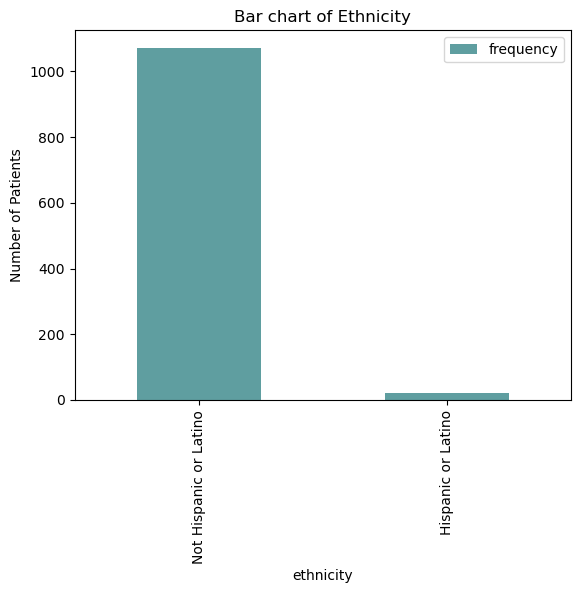

In [98]:
ethnicity_query = """SELECT  person.ethnicity_concept_id, concept.concept_name AS Ethnicity,
COUNT(concept.concept_name) AS frequency
FROM {}.person
INNER JOIN {}.concept
ON person.ethnicity_concept_id = concept.concept_id
GROUP BY person.ethnicity_concept_id, concept.concept_name
""".format(schema,schema)
ethnicity_table = pd.read_sql_query(ethnicity_query, conn)
display(ethnicity_table)
ethnicity_table.plot.bar(x = 'ethnicity', y = 'frequency', title = 'Bar chart of Ethnicity', color = 'cadetblue')
plt.ylabel('Number of Patients')
plt.show()





##### Bar chart illustrating the race of the patients:

81% of the patients in the database are white which is interesting since 60% of the US population are Non-hispanic white. That could say something about either where the data was collected or an inequlaity in the patients visiting the hospital 

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/427374564.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  race_table = pd.read_sql_query(race_query, conn)


,race_concept_id,race,count
0,8527,White,886
1,8516,Black or African American,121
2,0,No matching concept,86


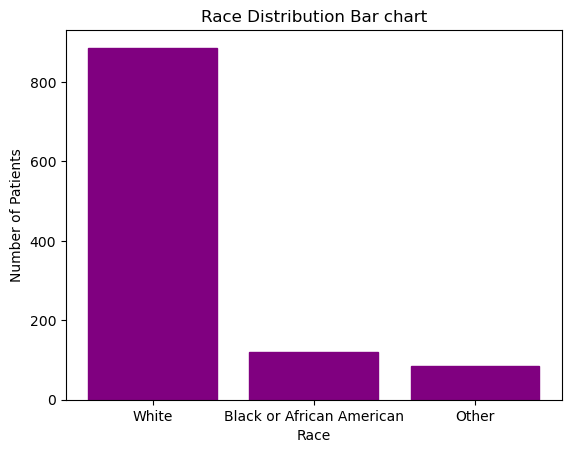

In [143]:
race_query = \
"""SELECT person.race_concept_id, concept.concept_name AS race,
COUNT(concept.concept_name)
FROM {}.person
INNER JOIN {}.concept
ON person.race_concept_id = concept.concept_id
GROUP BY concept.concept_name, person.race_concept_id
""".format(schema,schema)
race_table = pd.read_sql_query(race_query, conn)
display(race_table)

race_counts = pd.DataFrame(race_table)
labels = ['White', 'Black or African American', 'Other']
plt.bar(labels, race_counts['count'], color='purple', edgecolor="purple")
plt.title('Race Distribution Bar chart')
plt.xlabel('Race')
plt.ylabel('Number of Patients')
plt.show()


### Location

Which US states patients originate from.

This example shows most of the Patients orginate from California, Florida, Texas, New York 

In [100]:
#A table matching the location_id of patients to the state it represents 
location_query = \
""" 
SELECT person.person_id, location.state AS Location
FROM {}.person
INNER JOIN {}.location
ON person.location_id = location.location_id
GROUP BY location.state, person.person_id

""".format(schema,schema)
location_table = pd.read_sql_query(location_query, conn)


/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/1797635441.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  location_table = pd.read_sql_query(location_query, conn)


location,54,AK,AL,AR,AZ,CA,CO,CT,DC,DE,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
frequency,18,4,24,19,21,101,20,17,1,4,...,4,26,62,10,23,4,24,23,10,4


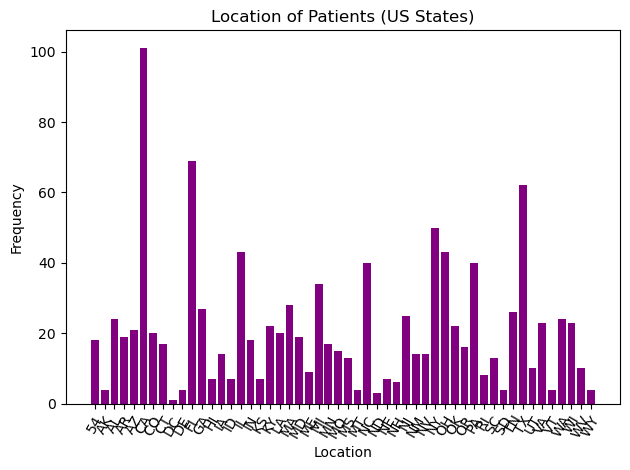

In [101]:
location_counts = pd.DataFrame(location_table.groupby('location').size(), columns=['frequency'])
display(location_counts.T)

x = location_counts['frequency']
plt.bar(location_counts.index,x, color='purple')

plt.title('Location of Patients (US States)')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

### Condition Analysis

##### Bar chart showing the top 30 most frequent condition and condition sources in the database

The most prevelant condition was Type 2 diabetes Mellitus which aligns well with the most prevelant condition source (source of the condition) of *"diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled"*. The next most prevelant condition was Atrial fibrilation, which also aligns with the 2nd most prevelant condition source being Atrial fibrillation. I found that for most of the topn 30 conditions, there was a condition source in the top 30 that would be a source of that condition. 

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/3105259622.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  conditions_table = pd.read_sql(conditions_query, conn)
/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/3105259622.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  csource_table = pd.read_sql(csource_query, conn)


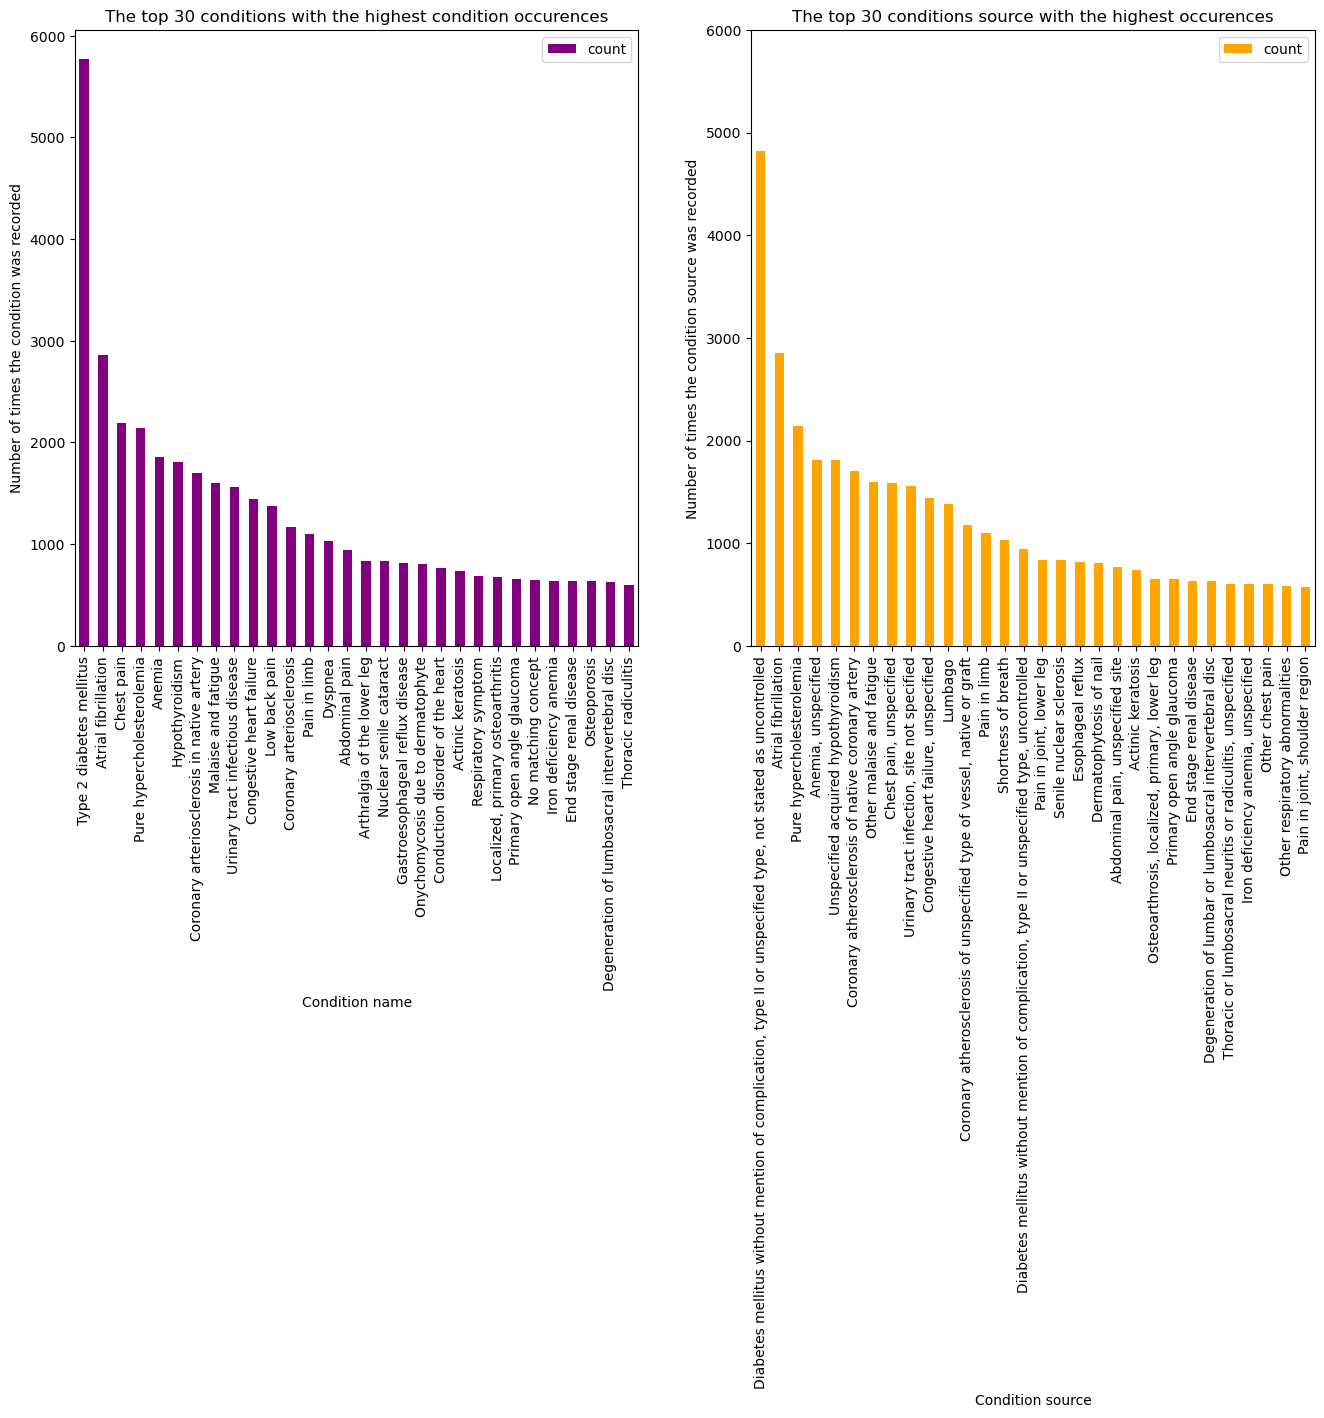

In [102]:
#Table detailing the Conditions patients were diagnosed with in descending order

conditions_query = \
"""
SELECT concept.concept_name, concept.concept_id,
COUNT (concept.concept_name)
FROM {}.condition_occurrence
INNER JOIN {}.concept
ON condition_occurrence.condition_concept_id = concept.concept_id
GROUP BY  concept.concept_name, concept.concept_id
ORDER BY count DESC
""".format(schema, schema)

conditions_table = pd.read_sql(conditions_query, conn)

 #Table detailing the sources of the conditions the patients were diagnosed with in descending order
csource_query = \
""" 
SELECT concept.concept_name, concept.concept_id,
COUNT (concept.concept_name)
FROM {}.condition_occurrence
INNER JOIN {}.concept
ON condition_occurrence.condition_source_concept_id = concept.concept_id
GROUP BY  concept.concept_name, concept.concept_id
ORDER BY count DESC
""".format(schema, schema)

csource_table = pd.read_sql(csource_query, conn)

fig, axes = plt.subplots(1, 2, figsize=(16,8))

top_30 = conditions_table.head(30)
plot = top_30.plot.bar(x='concept_name', y='count', color = 'purple', ax = axes[0], title = 'The top 30 conditions with the highest condition occurences')
axes[0].set_xlabel('Condition name')
axes[0].set_ylabel('Number of times the condition was recorded')

top_30_sources = csource_table.head(30)
plot = top_30_sources.plot.bar(x = 'concept_name', y = 'count', color = 'orange', ax = axes[1], title = 'The top 30 conditions source with the highest occurences')
axes[1].set_xlabel('Condition source')
axes[1].set_ylabel('Number of times the condition source was recorded')
axes[1].set_ylim(0, 6000)
plt.show()


##### Comparison of the most frequent conditions in different races to see how they compare.  
On Line 10 and 24, you can change the Where clauses to match the values in your OMOP database

The conditions between the 2 were similar up until the 5th most common condition which in white patients was *Anemia* but for Black or African American patients, it was *congestive heart failure*; In white patients, congestive heart failure takes the 10th spot. Another noticable different is with the condition *'Actinic Keratosis'*, which is the 20th most common condition for white patients, however it is not in the top 30 for Black or African American patients. 

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/325257489.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  white_condition_table = pd.read_sql(white_condition_query, conn)
/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/325257489.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  AA_condition_table = pd.read_sql(AA_condition_query, conn)


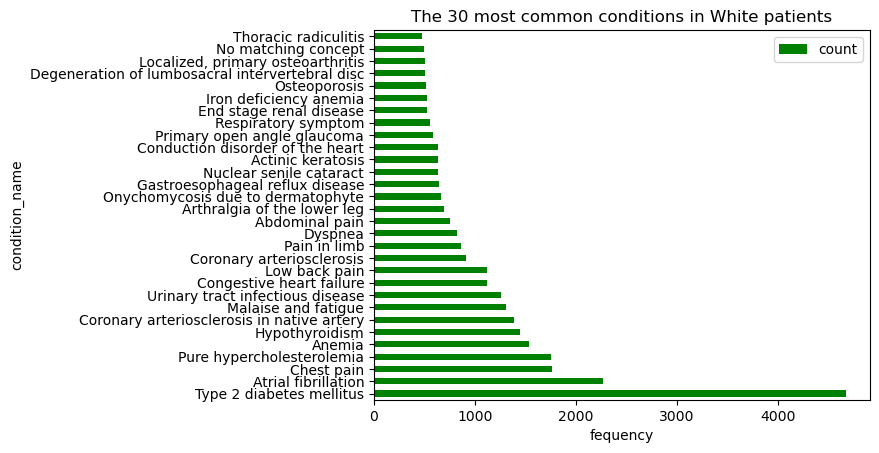

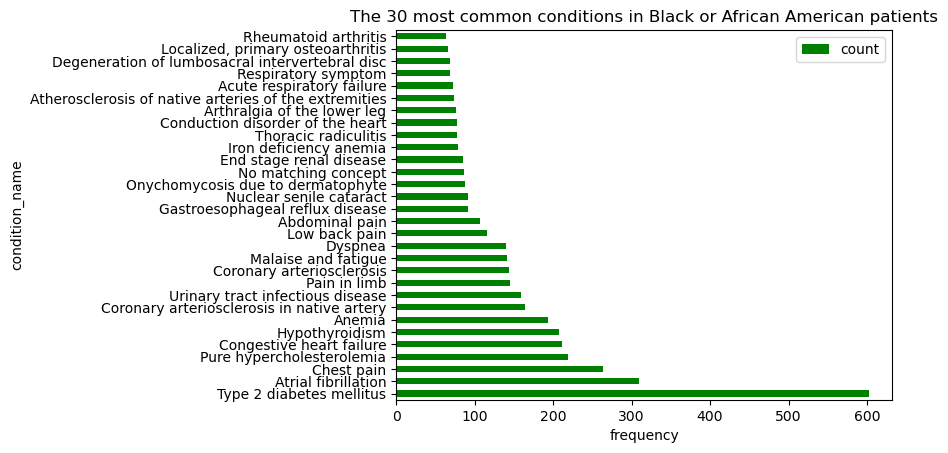

In [141]:
white_condition_query = \
"""  
SELECT concept.concept_name AS condition_name, concept.concept_id,
COUNT (concept.concept_name)
FROM {}.condition_occurrence
INNER JOIN {}.concept
ON condition_occurrence.condition_concept_id = concept.concept_id
INNER JOIN {}.person
ON condition_occurrence.person_id = person.person_id
WHERE person.race_concept_id = 8527
GROUP BY  concept.concept_name, concept.concept_id
ORDER BY count DESC LIMIT 30   
""".format(schema,schema,schema)

AA_condition_query = \
""" 
SELECT concept.concept_name AS condition_name, concept.concept_id,
COUNT (concept.concept_name)
FROM {}.condition_occurrence
INNER JOIN {}.concept
ON condition_occurrence.condition_concept_id = concept.concept_id
INNER JOIN {}.person
ON condition_occurrence.person_id = person.person_id
WHERE person.race_concept_id = 8516
GROUP BY  concept.concept_name, concept.concept_id
ORDER BY count DESC LIMIT 30   
""".format(schema,schema,schema)

white_condition_table = pd.read_sql(white_condition_query, conn)
white_condition_table.plot.barh(x='condition_name', y='count', color='green', title = 'The 30 most common conditions in White patients')
plt.xlabel('fequency')

AA_condition_table = pd.read_sql(AA_condition_query, conn)
AA_condition_table.plot.barh( x='condition_name', y='count', color='green', title = 'The 30 most common conditions in Black or African American patients')
plt.xlabel('frequency')
plt.show()



### Medical Observations

##### The Most common observations across patients vs  the  Most common observations for the Most common condition (Diabetes Mellitus)

 This block creates a table for the most popular observations for patients with type 2 diabetes mellitus.    
 You can easily change the *where* clause (line 12) to suit your needs and produce a graph for the condition you are looking for and you can change the Limit (line 15) to output as much or little as you like aswell as changing *DESC* to *ASC* to find the least popular conditions

The comaparison of observations made, is to a degree, what you would expect, with the top observation for patients with Type 2 Diabetes Mellitus being *'diabetic on insulin'*. However vaccinations were also a common observation in patients with diabetes which is interesting as that was also the most common observation across all patients.

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/2508356606.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  observation_table = pd.read_sql(observation_query, conn)
/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/2508356606.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  observation_condition_table = pd.read_sql(observation_condition_query, conn)


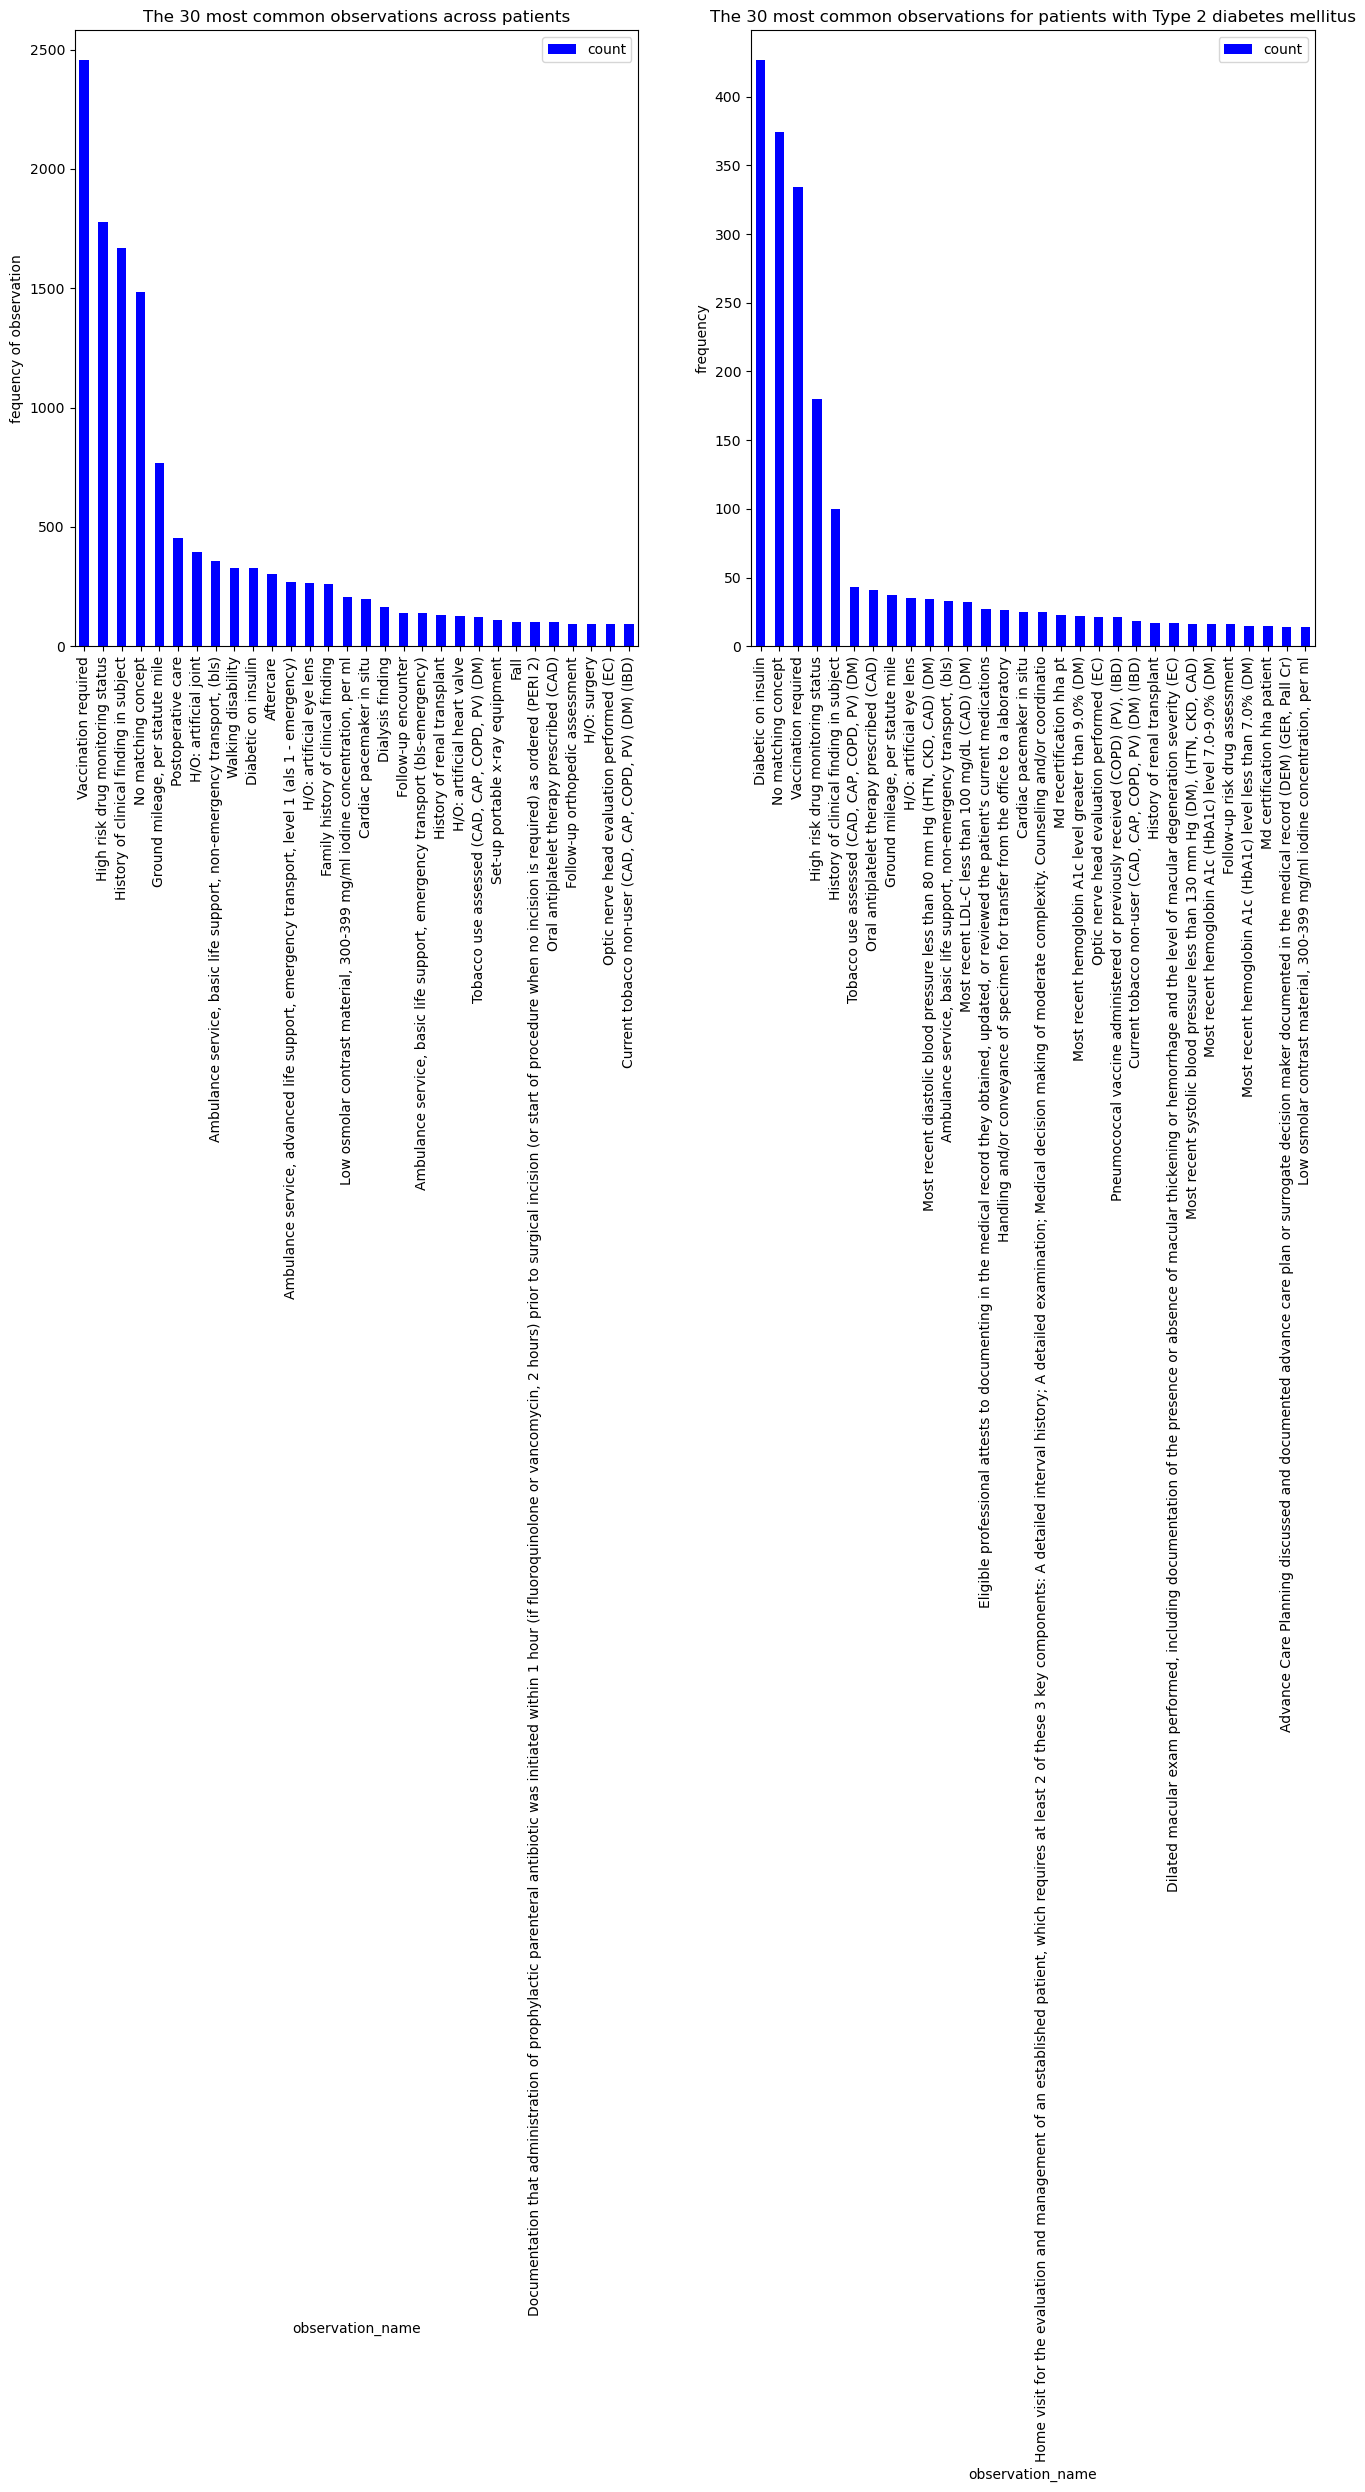

In [138]:
#The frequency of the top 30 observations made in the database
observation_query = \
"""SELECT concept.concept_name AS observation_name,
COUNT (concept.concept_name) 
FROM {}.observation
INNER JOIN {}.concept
ON observation.observation_concept_id = concept.concept_id
GROUP BY concept.concept_name
ORDER BY count DESC LIMIT 30
""".format(schema,schema)
observation_table = pd.read_sql(observation_query, conn)

observation_condition_query = \
"""
SELECT c_condition.concept_name AS Condition_name, c_observation.concept_name AS Observation_name, observation.observation_concept_id, 
COUNT (observation.observation_concept_id)
FROM {}.condition_occurrence 
INNER JOIN {}.observation
ON condition_occurrence.visit_occurrence_id = observation.visit_occurrence_id
LEFT JOIN {}.concept c_condition
ON condition_occurrence.condition_concept_id = c_condition.concept_id
LEFT JOIN {}.concept c_observation
ON observation.observation_concept_id = c_observation.concept_id
WHERE condition_occurrence.condition_concept_id = 201826
GROUP BY observation.observation_concept_id, 
c_condition.concept_name, c_observation.concept_name
ORDER BY count DESC LIMIT 30
""".format(schema,schema,schema,schema)
observation_condition_table = pd.read_sql(observation_condition_query, conn)

fig, axes = plt.subplots(1, 2, figsize=(16,8))
observation_table.plot.bar(ax = axes[0], x='observation_name', y='count', color='blue', title = 'The 30 most common observations across patients')
axes[0].set_ylabel('fequency of observation')

observation_condition_table.plot.bar(ax = axes[1], x='observation_name', y='count', color='blue', title = 'The 30 most common observations for patients with Type 2 diabetes mellitus')
axes[1].set_ylabel('frequency')
plt.show()


##### Drug administrations in Patients with type 2 diabetes and on insulin

This section joins the: observation, condition occurrence, dose_era and concept tables to find the names of the drugs that have the highest frequency in patients with type 2 diabetes on insulin.  
The *where* clause on line 16 can be edited to suit your needs.

* allow where clausesn to be passable 


/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/17276138.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  diabetes_drug_table = pd.read_sql(diabetes_drug_query, conn)
/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/17276138.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  afibrillation_drug_table = pd.read_sql(afibrillation_drug_query, conn)


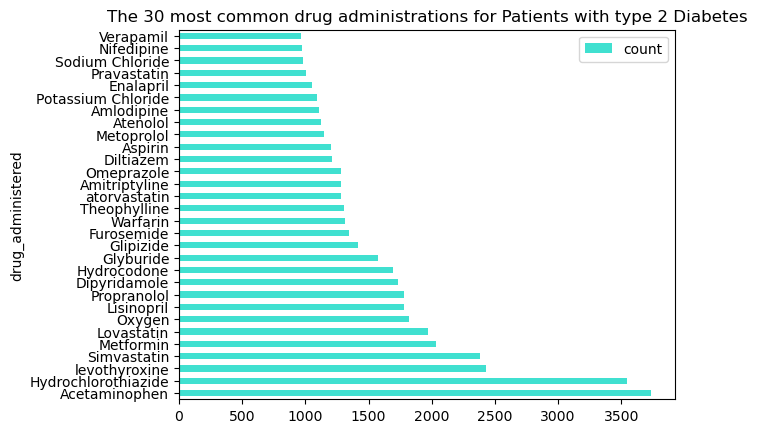

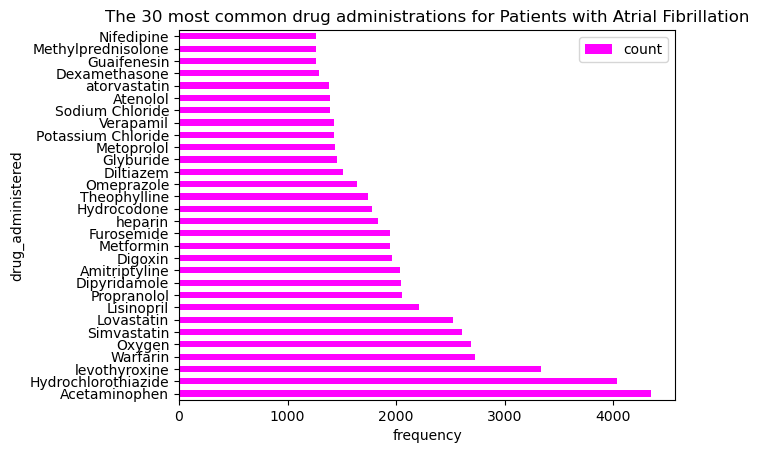

In [142]:
diabetes_drug_query = \
"""
SELECT c_condition.concept_name AS Condition_name, c_drug.concept_name AS Drug_administered,
COUNT (drug_era.drug_concept_id)
FROM {}.condition_occurrence 
INNER JOIN {}.observation
ON condition_occurrence.visit_occurrence_id = observation.visit_occurrence_id
JOIN {}.drug_era
ON condition_occurrence.person_id = drug_era.person_id
LEFT JOIN {}.concept c_condition
ON condition_occurrence.condition_concept_id = c_condition.concept_id
LEFT JOIN {}.concept c_drug
ON drug_era.drug_concept_id = c_drug.concept_id
WHERE condition_occurrence.condition_concept_id = 201826

GROUP BY c_drug.concept_name, c_condition.concept_name
ORDER BY count DESC
LIMIT 30
""".format(schema,schema,schema,schema,schema,schema)

afibrillation_drug_query = \
"""
SELECT c_condition.concept_name AS Condition_name, c_drug.concept_name AS Drug_administered,
COUNT (c_condition.concept_id)
FROM {}.condition_occurrence 
Inner JOIN {}.drug_era
ON condition_occurrence.person_id = drug_era.person_id
LEFT JOIN {}.concept c_condition
ON condition_occurrence.condition_concept_id = c_condition.concept_id
LEFT JOIN {}.concept c_drug
ON drug_era.drug_concept_id = c_drug.concept_id
WHERE condition_occurrence.condition_concept_id = 313217
GROUP BY c_drug.concept_name, c_condition.concept_name
ORDER BY count DESC
LIMIT 30
""".format(schema,schema,schema,schema,schema,schema)

diabetes_drug_table = pd.read_sql(diabetes_drug_query, conn)
diabetes_drug_table.plot.barh(x='drug_administered', y='count', color='turquoise', title = 'The 30 most common drug administrations for Patients with type 2 Diabetes')
afibrillation_drug_table = pd.read_sql(afibrillation_drug_query, conn)
afibrillation_drug_table.plot.barh(x='drug_administered', y='count', color='magenta', title = 'The 30 most common drug administrations for Patients with Atrial Fibrillation')
plt.xlabel('frequency')
plt.xlabel('frequency')
plt.show()


Table Detailing Drugs and their unit concept names

In [106]:
# Table detailing the drug 
drug_query = \
"""  
SELECT dose_era.person_id, c_drug.concept_name AS drug_concept_name, 
c_unit.concept_name AS unit_concept_name
FROM {}.dose_era 
LEFT JOIN {}.concept c_drug
ON dose_era.drug_concept_id = c_drug.concept_id
LEFT JOIN {}.concept c_unit
ON dose_era.unit_concept_id = c_unit.concept_id
""".format(schema,schema,schema)

drug_table = pd.read_sql(drug_query, conn)
display(drug_table)

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/1960088366.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  drug_table = pd.read_sql(drug_query, conn)


,person_id,drug_concept_name,unit_concept_name
0,780920,butalbital,Acetaminophen 500 MG / butalbital 50 MG / Caff...
1,895587,rosiglitazone,rosiglitazone 2 MG Oral Tablet [Avandia]
2,2225877,cherry allergenic extract,cherry allergenic extract 100 MG/ML Injectable...
3,392890,Fenofibrate,Fenofibrate 43 MG Oral Capsule [Antara]
4,1909513,oxybutynin,Oxybutynin chloride 5 MG Oral Tablet
...,...,...,...
57850,1877157,cefpodoxime,cefpodoxime 200 MG Oral Tablet
57851,1032527,Ondansetron,Ondansetron 4 MG Disintegrating Oral Tablet
57852,209548,Docusate,Docusate Calcium 240 MG Oral Capsule [Kaopecta...
57853,32674,Docusate,Docusate Sodium 100 MG Oral Capsule


### Patient Occurrence Analysis

This section explores how many occurences each patient has, and the blocks below create a scatter graph and a box-plot to show the density and averages of the amount of occurences patients may have

For figure 1, each spot represents an individual patient and it shows how many times the patient had a visit occurrence (each time they visited the hospital)

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/1203072783.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  occurrence_table = pd.read_sql(occurrence_query, conn)


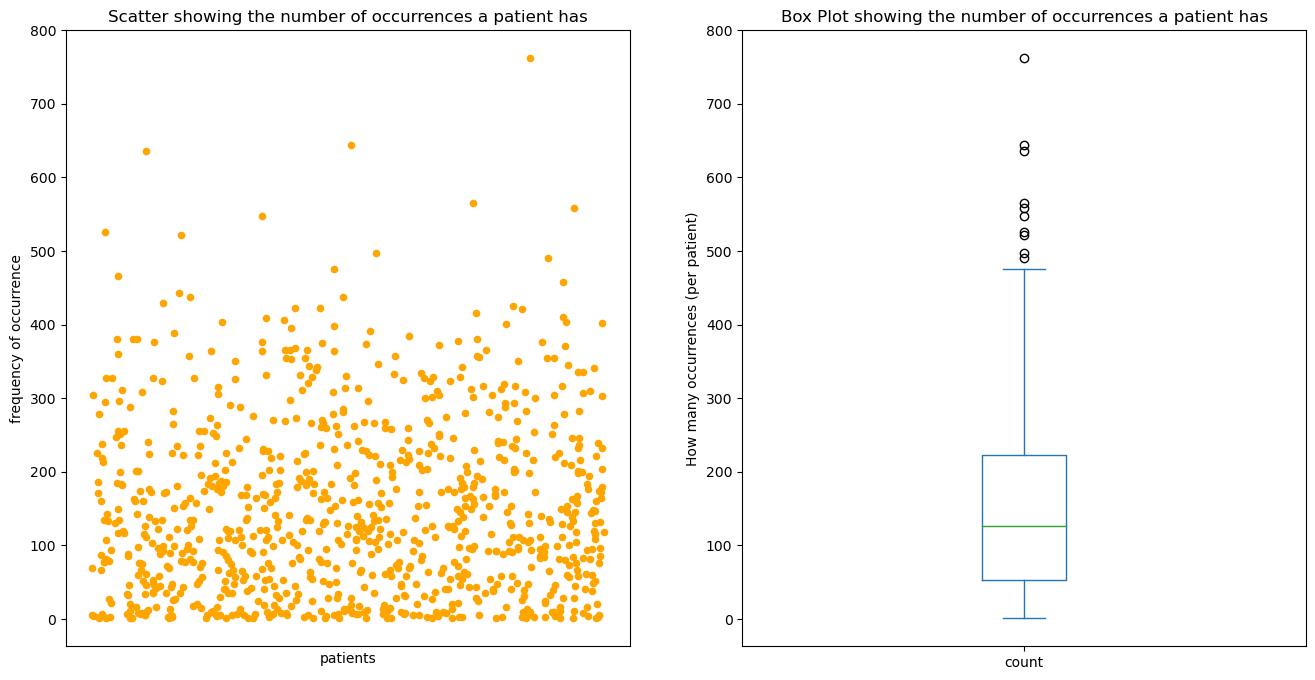

In [120]:
#How many visits a patient has had

occurrence_query = \
"""
SELECT condition_occurrence.person_id,
COUNT(condition_occurrence.person_id)
FROM {}.condition_occurrence
INNER JOIN {}.visit_occurrence
ON condition_occurrence.visit_occurrence_id = visit_occurrence.visit_occurrence_id
GROUP BY condition_occurrence.person_id
ORDER BY count DESC
""".format(schema, schema)
occurrence_table = pd.read_sql(occurrence_query, conn)

fig, axes = plt.subplots(1, 2, figsize=(16,8))
plot = occurrence_table.plot.scatter(ax = axes[0], x = 'person_id', y = 'count', color='orange', title = 'Scatter showing the number of occurrences a patient has')
axes[0].set_xticks([])
axes[0].set_xlabel('patients')
axes[0].set_ylabel('frequency of occurrence')

occurrence_table.plot.box(ax = axes[1], x='person_id')
axes[1].set_title("Box Plot showing the number of occurrences a patient has" )
axes[1].set_ylabel('How many occurrences (per patient)')
plt.show()

### Playing around with the data to create a config file

##### This is just information that could be a helpful starting point if creating a synthetic version of an OMOP database using [sqlsynthgen](https://github.com/alan-turing-institute/sqlsynthgen) 

A tutorial for creating synthetic data for OMOP databases can be found at https://sqlsynthgen.readthedocs.io/en/latest/tutorials/omop-cdm.html

A test to see if all the person_source_values are unique

In [110]:
# Testing to see if all the person_source_values are unique, which they are
person_SV_query = \
""" SELECT person_source_value,
COUNT (person_source_value)
FROM {}.person
GROUP BY person_source_value
""".format(schema)
person_SV_table = pd.read_sql(person_SV_query, conn)
display(person_SV_table)


/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/1162239221.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  person_SV_table = pd.read_sql(person_SV_query, conn)


,person_source_value,count
0,68FF8912868274AD,1
1,AF2DDBB5A1EB29E1,1
2,483319A86B8BFF41,1
3,AB7701FB3B0DD3F8,1
4,BCBBC2DC99F0D1DA,1
...,...,...
1088,12B7A20505008896,1
1089,8C7764358E64BDD0,1
1090,1495DDD59DFC90E8,1
1091,80FDF93D744F254D,1


Table that matches gender_source_value to gender_concept_id

In [111]:
#Matching source values to the concept_id's
genderSV_query = \
"""  
SELECT gender_source_value, gender_concept_id
FROM {}.person
GROUP BY gender_source_value, gender_concept_id
""".format(schema)

genderSV_table = pd.read_sql(genderSV_query,conn)
display(genderSV_table)

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/4066754421.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  genderSV_table = pd.read_sql(genderSV_query,conn)


,gender_source_value,gender_concept_id
0,2,8532
1,1,8507


The ranges for the start dates and end dates in the database, which could be helpful when curating synthetic versions of an OMOP database

In [112]:
#Gives me an idea of what year range of condition start date should be used for the config file
condition_start_date_query = """SELECT condition_start_date AS earliest_start_date
FROM {}.condition_occurrence
ORDER BY condition_start_date ASC LIMIT 1""".format(schema)

condition_start_date_query2 = """SELECT condition_start_date AS latest_start_date
FROM {}.condition_occurrence
ORDER BY condition_start_date DESC LIMIT 1""".format(schema)

condition_start_date_table = pd.read_sql(condition_start_date_query, conn)
condition_start_date_table2 = pd.read_sql(condition_start_date_query2, conn)

display(condition_start_date_table, condition_start_date_table2 )


/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/179956510.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  condition_start_date_table = pd.read_sql(condition_start_date_query, conn)
/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/179956510.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  condition_start_date_table2 = pd.read_sql(condition_start_date_query2, conn)


,earliest_start_date
0,2007-12-24


,latest_start_date
0,2010-12-31


In [113]:
#Gives me an idea of what year range should be used for the config file for the condition end dates
condition_end_date_query = """SELECT condition_end_date AS earliest_end_date
FROM {}.condition_occurrence
ORDER BY condition_start_date ASC LIMIT 1""".format(schema)

condition_end_date_query2 = """SELECT condition_end_date AS latest_end_date
FROM {}.condition_occurrence
ORDER BY condition_start_date DESC LIMIT 1""".format(schema)

condition_end_date_table = pd.read_sql(condition_end_date_query, conn)
condition_end_date_table2 = pd.read_sql(condition_end_date_query2, conn)

display(condition_end_date_table, condition_end_date_table2 )

/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/2680232012.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  condition_end_date_table = pd.read_sql(condition_end_date_query, conn)
/var/folders/_s/p62l7jqd6_s1r6qjbqy619b40000gr/T/ipykernel_98968/2680232012.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  condition_end_date_table2 = pd.read_sql(condition_end_date_query2, conn)


,earliest_end_date
0,2008-01-13


,latest_end_date
0,2010-12-31
